<a href="https://colab.research.google.com/github/stiwari-ds/data-science-competitions/blob/main/machinehack/analytics_olympiad22/notebooks/00_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

**Utils**

In [1]:
import gc
import os
import time
import warnings

gc.enable()
warnings.filterwarnings(action='ignore')

**Data analysis**

In [2]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

**Visualization**

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

**Modeling**

In [4]:
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

**Reproducibility**

In [5]:
SEED = 2311
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

**Data**

In [6]:
DATA_URL = 'https://raw.githubusercontent.com/stiwari-ds/data-science-competitions/main/machinehack/analytics_olympiad22/data'

train = pd.read_csv(f'{DATA_URL}/raw/train.csv')
test = pd.read_csv(f'{DATA_URL}/raw/test.csv')
sample_sub = pd.read_csv(f'{DATA_URL}/raw/submission.csv')

# Data Overview

In [7]:
train.head()

,ID,AGE,GENDER,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME,TYPE_OF_VEHICLE
0,816393,40-64,female,20-29y,university,middle class,0.6380,0.0,after 2015,0.0,0.0,37379,11000.0,0,0,0,0.0,Sports Car
1,251762,26-39,male,20-29y,high school,middle class,0.4757,1.0,before 2015,1.0,0.0,10238,9000.0,0,0,0,1.0,HatchBack
2,481952,40-64,male,20-29y,none,middle class,0.8398,1.0,before 2015,1.0,1.0,10238,12000.0,0,0,0,1.0,Sedan
3,3506,40-64,male,20-29y,high school,upper class,0.6825,1.0,before 2015,0.0,1.0,92099,6000.0,1,0,0,1.0,Sedan
4,498013,40-64,female,20-29y,none,working class,0.5722,1.0,after 2015,1.0,1.0,32122,15000.0,0,0,1,0.0,Sedan


In [8]:
sample_sub.head()

,OUTCOME
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


**Datatypes and dimensions**

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105000 entries, 0 to 104999
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   105000 non-null  int64  
 1   AGE                  105000 non-null  object 
 2   GENDER               105000 non-null  object 
 3   DRIVING_EXPERIENCE   105000 non-null  object 
 4   EDUCATION            105000 non-null  object 
 5   INCOME               105000 non-null  object 
 6   CREDIT_SCORE         105000 non-null  float64
 7   VEHICLE_OWNERSHIP    105000 non-null  float64
 8   VEHICLE_YEAR         105000 non-null  object 
 9   MARRIED              105000 non-null  float64
 10  CHILDREN             105000 non-null  float64
 11  POSTAL_CODE          105000 non-null  int64  
 12  ANNUAL_MILEAGE       105000 non-null  float64
 13  SPEEDING_VIOLATIONS  105000 non-null  int64  
 14  DUIS                 105000 non-null  int64  
 15  PAST_ACCIDENTS   

In [10]:
train.shape, test.shape, sample_sub.shape

((105000, 18), (45000, 17), (45000, 1))

**Missing values**

In [11]:
train.isna().sum().sum(), test.isna().sum().sum()

(0, 0)

No missing values.

**TARGET**

In [12]:
TARGET = 'OUTCOME'

In [13]:
train[TARGET].value_counts()

0.0    60622
1.0    44378
Name: OUTCOME, dtype: int64

In [14]:
train[TARGET].value_counts(normalize=True)

0.0    0.5774
1.0    0.4226
Name: OUTCOME, dtype: float64

Fairly balanced.

# Feature Exploration

In [15]:
def plot_cont(feature):
    """Plot side-by-side kdeplots for train and test
    data distribution of continuous feature.
    """
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20, 4))
    plt.suptitle(f'Feature: {feature}', fontweight='bold')
    sns.kdeplot(x=feature, data=train, ax=ax[0], cut=0)
    ax[0].set_title('Train data')
    sns.kdeplot(x=feature, data=test, ax=ax[1], cut=0)
    ax[1].set_title('Test data')
    fig.tight_layout()
    plt.show()

In [16]:
def plot_cont_vs_target(feature):
    """Plot kdeplot for distribution of continuous feature
    split by categories of Target variable.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
    plt.suptitle(f'{feature} vs. {TARGET}', fontweight='bold')
    sns.kdeplot(x=feature, data=train, hue=TARGET, ax=ax, cut=0)
    fig.tight_layout()
    plt.show()

### ID

In [17]:
train.ID.nunique(), train.shape[0]

(98485, 105000)

In [18]:
test.ID.nunique(), test.shape[0]

(43692, 45000)

Repeated IDs in train and test sets. Might be due to multiple incidents for same person.

In [19]:
len(set(train.ID.unique()) - set(test.ID.unique())), len(set(test.ID.unique()) - set(train.ID.unique()))

(93268, 38475)

In [20]:
98485 - 93268

5217

Overlapping IDs between train and test set. Some people with multiple incidents may have them divided between train and test set.

In [21]:
composite  = pd.concat(
    [train.drop(TARGET, axis=1), test], 
    axis=0, 
    ignore_index=True
)

In [22]:
composite.ID.nunique(), composite.shape[0]

(136960, 150000)

In [23]:
98485 + 43692

142177

As expected, actual number of unique IDs is less than sum of unique IDs in separate datasets.  
Some people are present once in the train set and once in the test set.

In [24]:
train.ID.value_counts()[:10]

101    127
102     39
103     14
104     12
106     11
105      8
107      8
112      6
108      6
176      6
Name: ID, dtype: int64

In [25]:
composite.ID.value_counts()[:10]

101    178
102     47
103     22
104     16
106     14
105     10
107      9
109      8
108      8
326      7
Name: ID, dtype: int64

In [26]:
composite.duplicated().sum()

0

In [27]:
train.loc[train.ID == 108]

,ID,AGE,GENDER,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME,TYPE_OF_VEHICLE
16053,108,65+,male,20-29y,none,upper class,0.5973,1.0,after 2015,1.0,1.0,10238,8000.0,0,0,2,1.0,Sports Car
18546,108,26-39,male,10-19y,high school,poverty,0.6211,1.0,before 2015,1.0,0.0,10238,13000.0,0,0,0,1.0,HatchBack
25935,108,65+,male,10-19y,university,working class,0.5544,1.0,after 2015,1.0,1.0,33654,14000.0,0,0,1,1.0,Sports Car
26982,108,26-39,female,20-29y,university,upper class,0.8240,0.0,after 2015,0.0,0.0,10238,12000.0,0,1,0,0.0,SUV
34688,108,26-39,male,10-19y,none,poverty,0.8090,1.0,after 2015,0.0,0.0,10238,12000.0,1,0,0,1.0,Sports Car
87525,108,40-64,female,0-9y,high school,upper class,0.7332,1.0,before 2015,1.0,0.0,10238,13000.0,0,0,5,1.0,HatchBack


In [28]:
composite.loc[composite.ID == 108]

,ID,AGE,GENDER,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,TYPE_OF_VEHICLE
16053,108,65+,male,20-29y,none,upper class,0.5973,1.0,after 2015,1.0,1.0,10238,8000.0,0,0,2,Sports Car
18546,108,26-39,male,10-19y,high school,poverty,0.6211,1.0,before 2015,1.0,0.0,10238,13000.0,0,0,0,HatchBack
25935,108,65+,male,10-19y,university,working class,0.5544,1.0,after 2015,1.0,1.0,33654,14000.0,0,0,1,Sports Car
26982,108,26-39,female,20-29y,university,upper class,0.8240,0.0,after 2015,0.0,0.0,10238,12000.0,0,1,0,SUV
34688,108,26-39,male,10-19y,none,poverty,0.8090,1.0,after 2015,0.0,0.0,10238,12000.0,1,0,0,Sports Car
87525,108,40-64,female,0-9y,high school,upper class,0.7332,1.0,before 2015,1.0,0.0,10238,13000.0,0,0,5,HatchBack
142897,108,65+,male,0-9y,high school,upper class,0.6141,1.0,after 2015,1.0,0.0,10238,8000.0,0,0,0,Sports Car
147412,108,65+,female,20-29y,none,upper class,0.4296,1.0,after 2015,1.0,1.0,30317,9000.0,0,0,0,Sports Car


Same ID is attached to obviously different people. This why there were no duplicate rows even though IDs were same.  

Previous theory about same person being in repeated incidents can be discarded.

We can create column(s) based on whether a particular ID is present multiple times or not, and check if it is statistically significant. It may be significant due to some case we haven't considered or cannot confirm. E.g. multiple parties involved in same incident.

After creating new columns we can drop ID as a feature.

### New columns: IS_ID_REPEATED, ID_COUNT

In [29]:
ID_counts = composite.ID.value_counts()
composite['IS_ID_REPEATED'] = composite.ID.apply(lambda x: ID_counts[x] > 1).astype('int8')
composite['ID_COUNT'] = composite.ID.apply(lambda x: ID_counts[x])

In [30]:
train['IS_ID_REPEATED'] = composite.IS_ID_REPEATED[:105000].values
test['IS_ID_REPEATED'] = composite.IS_ID_REPEATED[105000:].values

train['ID_COUNT'] = composite.ID_COUNT[:105000].values
test['ID_COUNT'] = composite.ID_COUNT[105000:].values

In [31]:
train.IS_ID_REPEATED.value_counts(normalize=True)

0    0.8368
1    0.1632
Name: IS_ID_REPEATED, dtype: float64

In [32]:
test.IS_ID_REPEATED.value_counts(normalize=True)

0    0.8325
1    0.1675
Name: IS_ID_REPEATED, dtype: float64

In [33]:
train.groupby('IS_ID_REPEATED')[TARGET].value_counts(normalize=True)

IS_ID_REPEATED  OUTCOME
0               0.0        0.5777
                1.0        0.4223
1               0.0        0.5753
                1.0        0.4247
Name: OUTCOME, dtype: float64

In [34]:
train.loc[train.ID_COUNT == 1][TARGET].value_counts(normalize=True)

0.0    0.5777
1.0    0.4223
Name: OUTCOME, dtype: float64

In [35]:
train.loc[train.ID_COUNT > 1][TARGET].value_counts(normalize=True)

0.0    0.5753
1.0    0.4247
Name: OUTCOME, dtype: float64

### AGE

In [36]:
train.AGE.value_counts(normalize=True)

40-64    0.3211
65+      0.3139
26-39    0.1906
16-25    0.1743
Name: AGE, dtype: float64

In [37]:
test.AGE.value_counts(normalize=True)

40-64    0.3204
65+      0.3173
26-39    0.1863
16-25    0.1761
Name: AGE, dtype: float64

In [38]:
train.groupby('AGE')[TARGET].value_counts(normalize=True)

AGE    OUTCOME
16-25  0.0        0.5817
       1.0        0.4183
26-39  0.0        0.5770
       1.0        0.4230
40-64  0.0        0.5748
       1.0        0.4252
65+    0.0        0.5778
       1.0        0.4222
Name: OUTCOME, dtype: float64

In [39]:
category_mappings = {}
category_mappings['AGE'] = {'16-25': 0, '26-39': 1, '40-64': 2, '65+': 3}

### GENDER

In [40]:
train.GENDER.value_counts(normalize=True)

male      0.6221
female    0.3779
Name: GENDER, dtype: float64

In [41]:
test.GENDER.value_counts(normalize=True)

male      0.6213
female    0.3787
Name: GENDER, dtype: float64

In [42]:
train.groupby('GENDER')[TARGET].value_counts(normalize=True)

GENDER  OUTCOME
female  0.0        0.5699
        1.0        0.4301
male    0.0        0.5819
        1.0        0.4181
Name: OUTCOME, dtype: float64

In [43]:
category_mappings['GENDER'] = {'female': 0, 'male': 1}

### DRIVING EXPERIENCE

In [44]:
train.DRIVING_EXPERIENCE.value_counts(normalize=True)

20-29y    0.3571
0-9y      0.3153
10-19y    0.2391
30y+      0.0885
Name: DRIVING_EXPERIENCE, dtype: float64

In [45]:
test.DRIVING_EXPERIENCE.value_counts(normalize=True)

20-29y    0.3609
0-9y      0.3168
10-19y    0.2368
30y+      0.0855
Name: DRIVING_EXPERIENCE, dtype: float64

In [46]:
train.groupby('DRIVING_EXPERIENCE')[TARGET].value_counts(normalize=True)

DRIVING_EXPERIENCE  OUTCOME
0-9y                0.0        0.5808
                    1.0        0.4192
10-19y              0.0        0.5869
                    1.0        0.4131
20-29y              0.0        0.5687
                    1.0        0.4313
30y+                0.0        0.5741
                    1.0        0.4259
Name: OUTCOME, dtype: float64

In [47]:
category_mappings['DRIVING_EXPERIENCE'] = {'0-9y': 0, '10-19y': 1, '20-29y': 2, '30y+': 3}

### EDUCATION

In [48]:
train.EDUCATION.value_counts(normalize=True)

high school    0.4437
university     0.2973
none           0.2590
Name: EDUCATION, dtype: float64

In [49]:
test.EDUCATION.value_counts(normalize=True)

high school    0.4439
university     0.2964
none           0.2597
Name: EDUCATION, dtype: float64

In [50]:
train.groupby('EDUCATION')[TARGET].value_counts(normalize=True)

EDUCATION    OUTCOME
high school  0.0        0.5765
             1.0        0.4235
none         0.0        0.5759
             1.0        0.4241
university   0.0        0.5799
             1.0        0.4201
Name: OUTCOME, dtype: float64

In [51]:
category_mappings['EDUCATION'] = {'none': 0, 'high school': 1, 'university': 2}

### INCOME

In [52]:
train.INCOME.value_counts(normalize=True)

upper class      0.4883
working class    0.2329
middle class     0.1404
poverty          0.1384
Name: INCOME, dtype: float64

In [53]:
test.INCOME.value_counts(normalize=True)

upper class      0.4866
working class    0.2333
middle class     0.1409
poverty          0.1393
Name: INCOME, dtype: float64

In [54]:
train.groupby('INCOME')[TARGET].value_counts(normalize=True)

INCOME         OUTCOME
middle class   0.0        0.5795
               1.0        0.4205
poverty        0.0        0.5735
               1.0        0.4265
upper class    0.0        0.5767
               1.0        0.4233
working class  0.0        0.5798
               1.0        0.4202
Name: OUTCOME, dtype: float64

In [55]:
category_mappings['INCOME'] = {'poverty': 0, 'working class': 1, 'middle class': 2, 'upper class': 3}

### CREDIT_SCORE

In [56]:
train.CREDIT_SCORE.describe()

count    105000.0000
mean          0.6022
std           0.1380
min           0.0669
25%           0.5149
50%           0.6011
75%           0.7032
max           0.9541
Name: CREDIT_SCORE, dtype: float64

In [57]:
test.CREDIT_SCORE.describe()

count    45000.0000
mean         0.6020
std          0.1374
min          0.0638
25%          0.5146
50%          0.5999
75%          0.7026
max          0.9518
Name: CREDIT_SCORE, dtype: float64

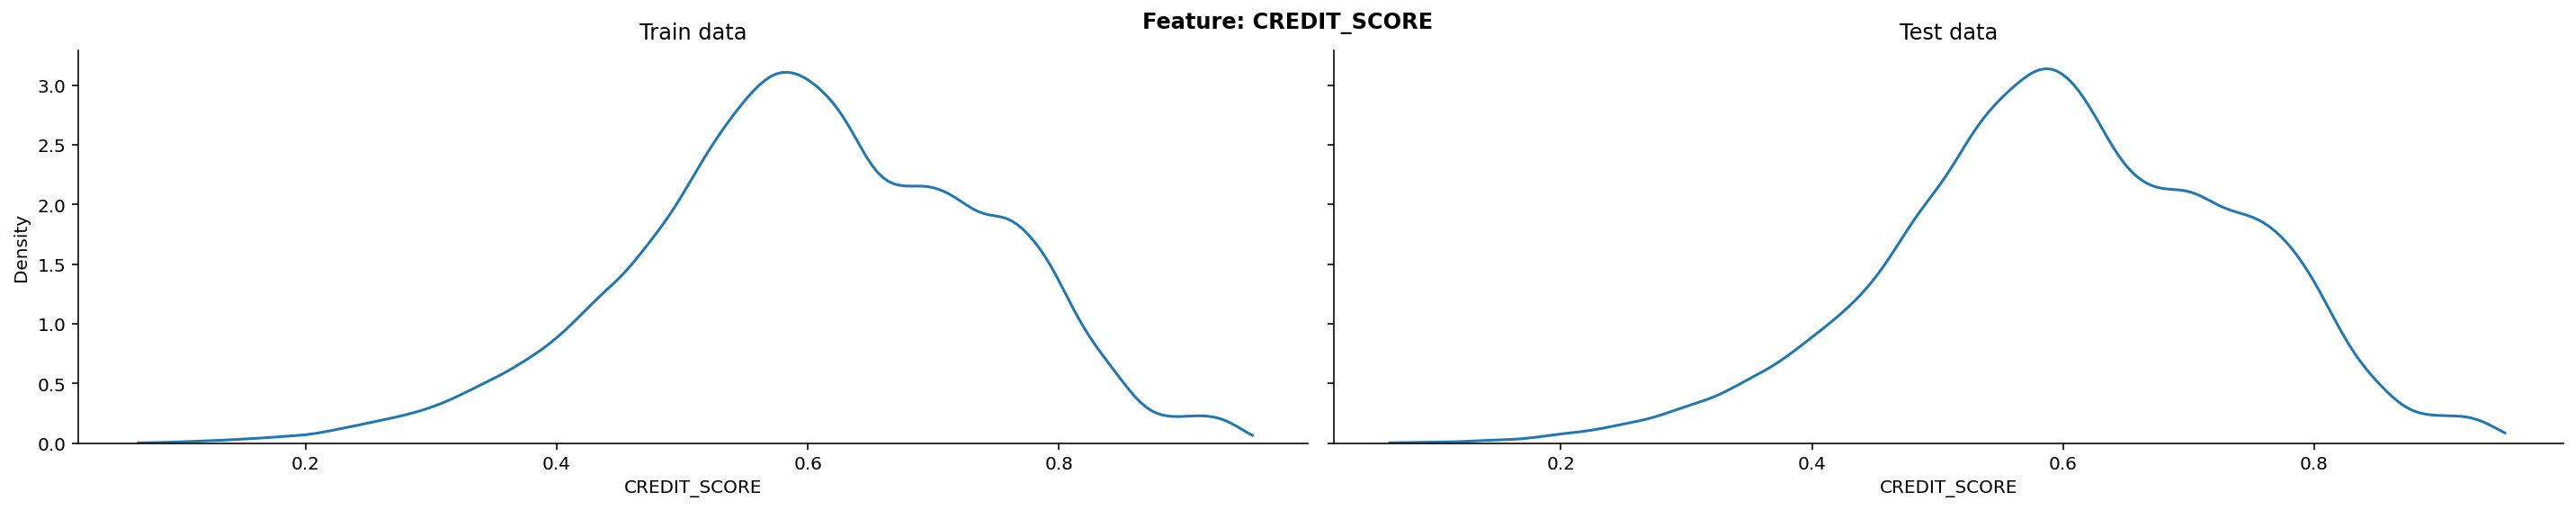

In [58]:
plot_cont('CREDIT_SCORE')

In [59]:
train.groupby(TARGET)['CREDIT_SCORE'].describe()

,count,mean,std,min,25%,50%,75%,max
OUTCOME,,,,,,,,
0.0,60622.0,0.6025,0.1376,0.0669,0.5154,0.6013,0.7033,0.9538
1.0,44378.0,0.6017,0.1386,0.0798,0.5141,0.6007,0.7031,0.9541


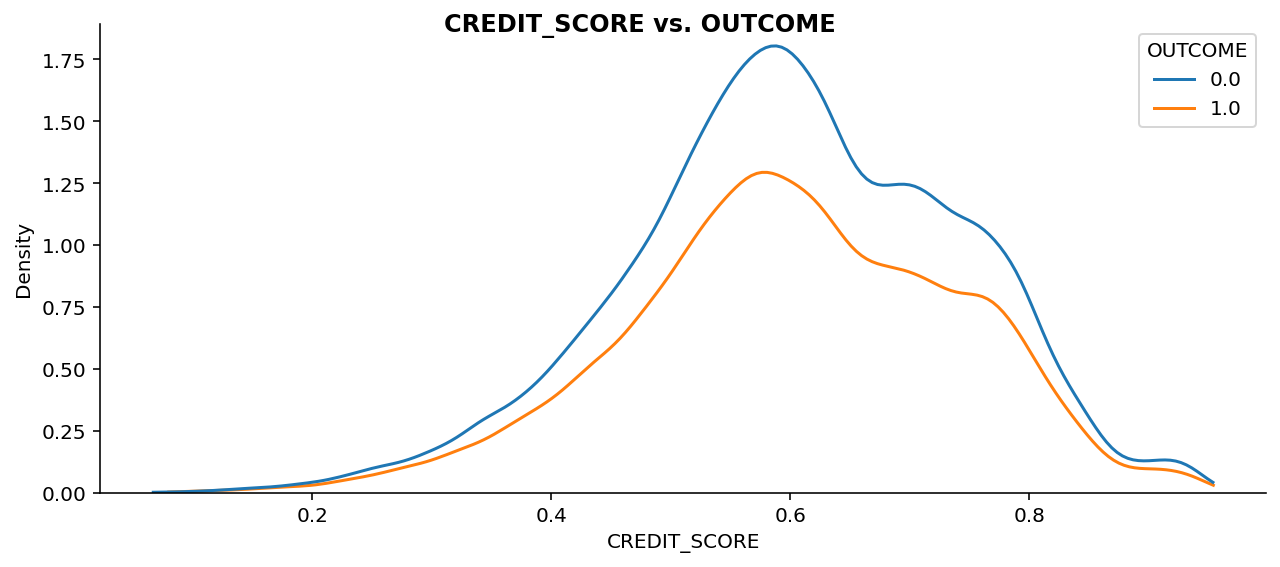

In [60]:
plot_cont_vs_target('CREDIT_SCORE')

### VEHICLE_OWNERSHIP

In [61]:
train.VEHICLE_OWNERSHIP.value_counts(normalize=True)

1.0    0.827
0.0    0.173
Name: VEHICLE_OWNERSHIP, dtype: float64

In [62]:
test.VEHICLE_OWNERSHIP.value_counts(normalize=True)

1.0    0.8268
0.0    0.1732
Name: VEHICLE_OWNERSHIP, dtype: float64

In [63]:
train.groupby('VEHICLE_OWNERSHIP')[TARGET].value_counts(normalize=True)

VEHICLE_OWNERSHIP  OUTCOME
0.0                0.0        0.574
                   1.0        0.426
1.0                0.0        0.578
                   1.0        0.422
Name: OUTCOME, dtype: float64

### VEHICLE_YEAR

In [64]:
train.VEHICLE_YEAR.value_counts(normalize=True)

before 2015    0.5477
after 2015     0.4523
Name: VEHICLE_YEAR, dtype: float64

In [65]:
test.VEHICLE_YEAR.value_counts(normalize=True)

before 2015    0.5476
after 2015     0.4524
Name: VEHICLE_YEAR, dtype: float64

In [66]:
train.groupby('VEHICLE_YEAR')[TARGET].value_counts(normalize=True)

VEHICLE_YEAR  OUTCOME
after 2015    0.0        0.5778
              1.0        0.4222
before 2015   0.0        0.5770
              1.0        0.4230
Name: OUTCOME, dtype: float64

In [67]:
category_mappings['VEHICLE_YEAR'] = {'before 2015': 0, 'after 2015': 1}

### MARRIED

In [68]:
train.MARRIED.value_counts(normalize=True)

1.0    0.5841
0.0    0.4159
Name: MARRIED, dtype: float64

In [69]:
test.MARRIED.value_counts(normalize=True)

1.0    0.5826
0.0    0.4174
Name: MARRIED, dtype: float64

In [70]:
train.groupby('MARRIED')[TARGET].value_counts(normalize=True)

MARRIED  OUTCOME
0.0      0.0        0.5738
         1.0        0.4262
1.0      0.0        0.5799
         1.0        0.4201
Name: OUTCOME, dtype: float64

### CHILDREN

In [71]:
train.CHILDREN.value_counts(normalize=True)

1.0    0.52
0.0    0.48
Name: CHILDREN, dtype: float64

In [72]:
test.CHILDREN.value_counts(normalize=True)

1.0    0.524
0.0    0.476
Name: CHILDREN, dtype: float64

In [73]:
train.groupby('CHILDREN')[TARGET].value_counts(normalize=True)

CHILDREN  OUTCOME
0.0       0.0        0.5783
          1.0        0.4217
1.0       0.0        0.5765
          1.0        0.4235
Name: OUTCOME, dtype: float64

### POSTAL_CODE

In [74]:
train.POSTAL_CODE.nunique(), test.POSTAL_CODE.nunique()

(10937, 7003)

In [75]:
train.POSTAL_CODE.apply(str).apply(len).value_counts()

5    105000
Name: POSTAL_CODE, dtype: int64

In [76]:
test.POSTAL_CODE.apply(str).apply(len).value_counts()

5    45000
Name: POSTAL_CODE, dtype: int64

All postal codes are 5-digit integers.

Assuming that these postal codes follow the arrangement of actual postal codes, the first digit corresponds to region, first two digits to sub-region, and so on.

In [77]:
train.POSTAL_CODE.apply(lambda x: str(x)[:1]).value_counts()

1    78410
3    20204
9     3462
2     2825
4       77
8       22
Name: POSTAL_CODE, dtype: int64

In [78]:
train.POSTAL_CODE.apply(lambda x: str(x)[:2]).value_counts().to_frame().T

,10,33,34,92,32,35,31,36,30,37,29,28,38,91,27,18,23,20,16,24,17,25,26,21,22,19,15,14,39,13,90,12,11,41,40,89,42,43,44,87,45,88,46
POSTAL_CODE,77608,3191,3082,3058,2937,2668,2474,2131,1926,1249,1239,597,466,362,179,130,128,125,122,118,117,112,110,109,108,105,98,96,80,70,42,41,23,20,20,18,18,10,5,3,3,1,1


In [79]:
train.POSTAL_CODE.apply(lambda x: str(x)[:2]).nunique(), test.POSTAL_CODE.apply(lambda x: str(x)[:2]).nunique()

(43, 40)

In [80]:
train.POSTAL_CODE.apply(lambda x: str(x)[:3]).nunique(), test.POSTAL_CODE.apply(lambda x: str(x)[:3]).nunique()

(361, 325)

In [81]:
train.POSTAL_CODE.apply(lambda x: str(x)[:4]).nunique(), test.POSTAL_CODE.apply(lambda x: str(x)[:4]).nunique()

(2436, 1832)

In [82]:
train.POSTAL_CODE.value_counts(normalize=True)[:5]

10238    0.7391
92101    0.0126
92100    0.0038
92099    0.0015
92098    0.0012
Name: POSTAL_CODE, dtype: float64

In [83]:
test.POSTAL_CODE.value_counts(normalize=True)[:5]

10238    0.7410
92101    0.0129
92100    0.0036
92099    0.0017
92098    0.0011
Name: POSTAL_CODE, dtype: float64

Majority of the records are from a single postal code i.e., 10238.

In [84]:
train['POSTAL_CODE_REGION'] = train['POSTAL_CODE'].apply(lambda x: x // 10000).astype('int8') #only 1st digit
test['POSTAL_CODE_REGION'] = test['POSTAL_CODE'].apply(lambda x: x // 10000).astype('int8')

In [85]:
train['POSTAL_CODE_SUBREGION'] = train['POSTAL_CODE'].apply(lambda x: x // 1000).astype('int8') #first 2 digits
test['POSTAL_CODE_SUBREGION'] = test['POSTAL_CODE'].apply(lambda x: x // 1000).astype('int8')

In [86]:
train.groupby('POSTAL_CODE_REGION')[TARGET].value_counts(normalize=True)

POSTAL_CODE_REGION  OUTCOME
1                   0.0        0.5763
                    1.0        0.4237
2                   0.0        0.5876
                    1.0        0.4124
3                   0.0        0.5795
                    1.0        0.4205
4                   0.0        0.5714
                    1.0        0.4286
8                   0.0        0.7727
                    1.0        0.2273
9                   0.0        0.5786
                    1.0        0.4214
Name: OUTCOME, dtype: float64

Distribution for region 8 is different but it is insignificant due to the small number of samples (only 22).

### ANNUAL_MILEAGE

In [87]:
train.ANNUAL_MILEAGE.describe()

count    105000.0000
mean      11061.2286
std        2972.3555
min        2000.0000
25%        9000.0000
50%       11000.0000
75%       13000.0000
max       21000.0000
Name: ANNUAL_MILEAGE, dtype: float64

In [88]:
test.ANNUAL_MILEAGE.describe()

count    45000.0000
mean     11084.1778
std       2966.5840
min       2000.0000
25%       9000.0000
50%      11000.0000
75%      13000.0000
max      21000.0000
Name: ANNUAL_MILEAGE, dtype: float64

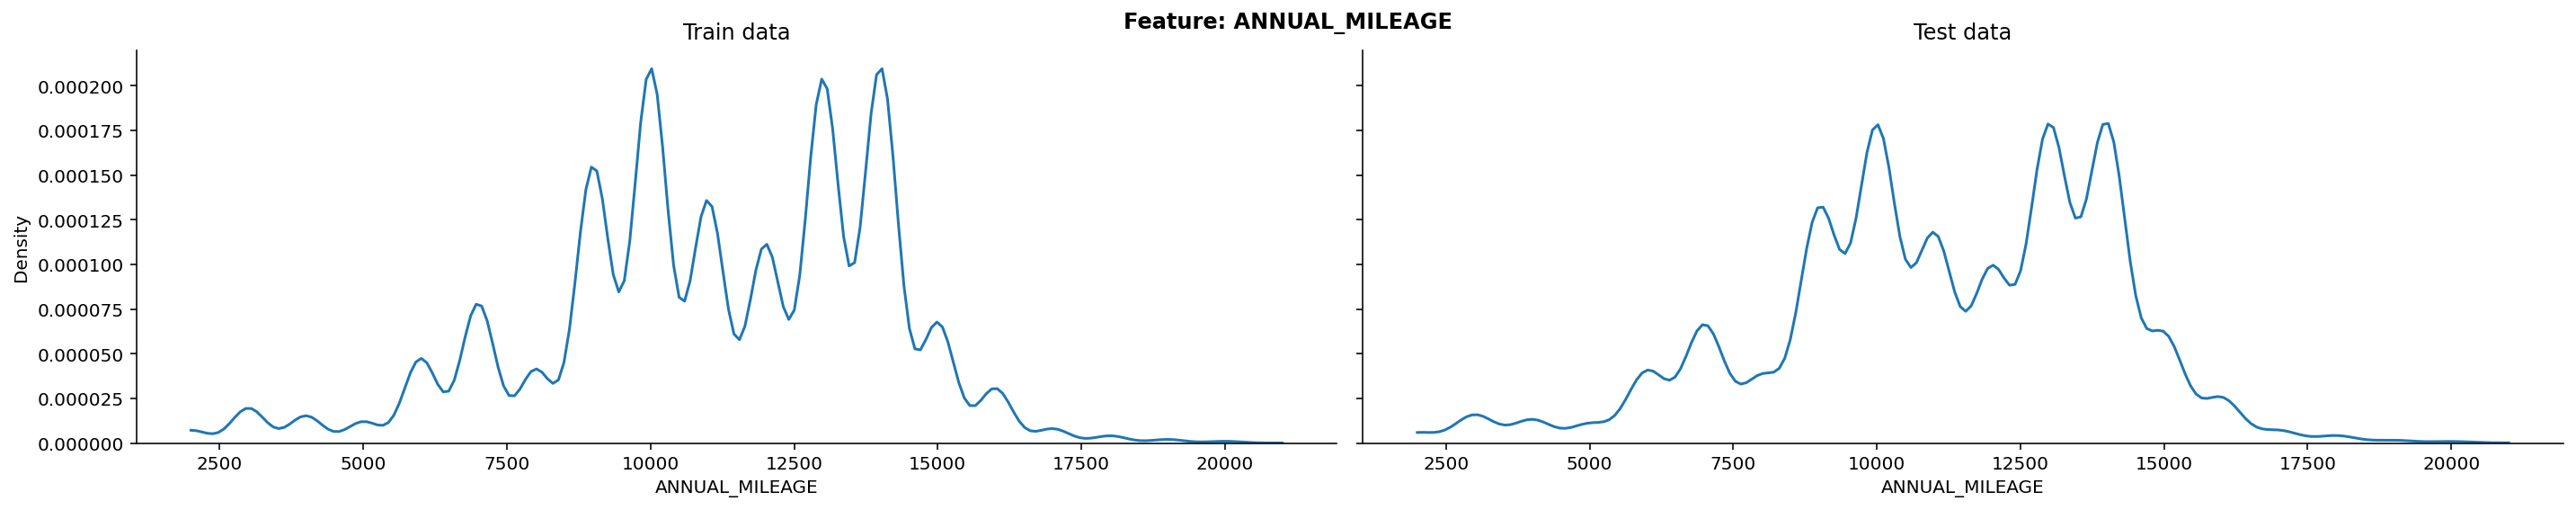

In [89]:
plot_cont('ANNUAL_MILEAGE')

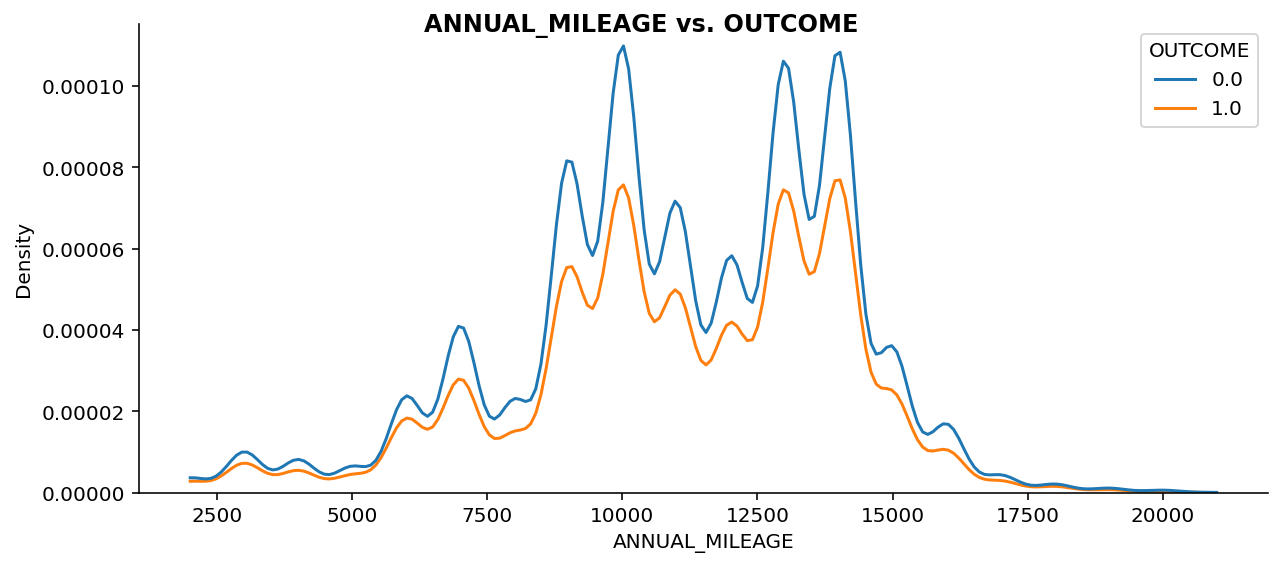

In [90]:
plot_cont_vs_target('ANNUAL_MILEAGE')

In [91]:
train.groupby(TARGET)['ANNUAL_MILEAGE'].describe()

,count,mean,std,min,25%,50%,75%,max
OUTCOME,,,,,,,,
0.0,60622.0,11064.0362,2970.6821,2000.0,9000.0,11000.0,13000.0,21000.0
1.0,44378.0,11057.3933,2974.6691,2000.0,9000.0,11000.0,13000.0,21000.0


In [92]:
train.ANNUAL_MILEAGE.nunique(), test.ANNUAL_MILEAGE.nunique()

(20, 20)

In [93]:
np.asarray(sorted(train.ANNUAL_MILEAGE.unique()))

array([ 2000.,  3000.,  4000.,  5000.,  6000.,  7000.,  8000.,  9000.,
       10000., 11000., 12000., 13000., 14000., 15000., 16000., 17000.,
       18000., 19000., 20000., 21000.])

In [94]:
np.asarray(sorted(test.ANNUAL_MILEAGE.unique()))

array([ 2000.,  3000.,  4000.,  5000.,  6000.,  7000.,  8000.,  9000.,
       10000., 11000., 12000., 13000., 14000., 15000., 16000., 17000.,
       18000., 19000., 20000., 21000.])

In [95]:
train['ANNUAL_MILEAGE_K'] = train.ANNUAL_MILEAGE.apply(lambda x: x // 1000).astype('int')
test['ANNUAL_MILEAGE_K'] = test.ANNUAL_MILEAGE.apply(lambda x: x // 1000).astype('int')

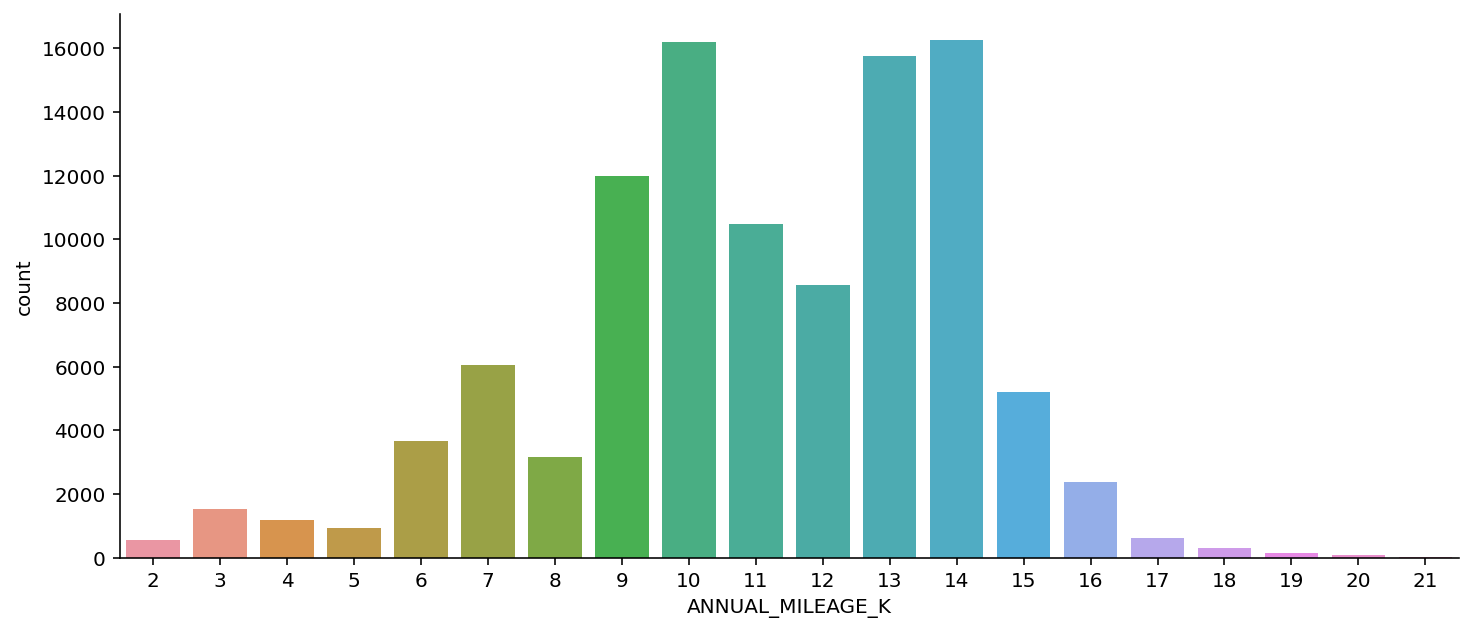

In [96]:
plt.figure(figsize=(12, 5))
sns.countplot(x='ANNUAL_MILEAGE_K', data=train)
plt.show()

In [97]:
def get_mileage_range(x):
    if x < 6: return 0
    elif x < 9: return 1
    elif x < 12: return 2
    elif x < 15: return 3
    else: return 4

train['ANNUAL_MILEAGE_RANGE'] = train.ANNUAL_MILEAGE_K.apply(get_mileage_range).astype('int8')
test['ANNUAL_MILEAGE_RANGE'] = test.ANNUAL_MILEAGE_K.apply(get_mileage_range).astype('int8')

In [98]:
train.groupby('ANNUAL_MILEAGE_RANGE')[TARGET].value_counts(normalize=True)

ANNUAL_MILEAGE_RANGE  OUTCOME
0                     0.0        0.5751
                      1.0        0.4249
1                     0.0        0.5774
                      1.0        0.4226
2                     0.0        0.5801
                      1.0        0.4199
3                     0.0        0.5726
                      1.0        0.4274
4                     0.0        0.5880
                      1.0        0.4120
Name: OUTCOME, dtype: float64

### SPEEDING_VIOLATIONS

In [99]:
train.SPEEDING_VIOLATIONS.describe()

count    105000.0000
mean          0.6757
std           1.3837
min           0.0000
25%           0.0000
50%           0.0000
75%           1.0000
max          20.0000
Name: SPEEDING_VIOLATIONS, dtype: float64

In [100]:
test.SPEEDING_VIOLATIONS.describe()

count    45000.0000
mean         0.6888
std          1.4226
min          0.0000
25%          0.0000
50%          0.0000
75%          1.0000
max         17.0000
Name: SPEEDING_VIOLATIONS, dtype: float64

Most of the records have 0 speeding violations so we can create a boolean column from this data. 

In [101]:
train['HAS_PRIOR_SPEEDING_VIOLATIONS'] = (train['SPEEDING_VIOLATIONS'] > 0).astype('int8')
test['HAS_PRIOR_SPEEDING_VIOLATIONS'] = (test['SPEEDING_VIOLATIONS'] > 0).astype('int8')

### DUIS

In [102]:
train.DUIS.describe()

count    105000.0000
mean          0.1297
std           0.5897
min           0.0000
25%           0.0000
50%           0.0000
75%           0.0000
max           6.0000
Name: DUIS, dtype: float64

In [103]:
test.DUIS.describe()

count    45000.0000
mean         0.1302
std          0.5930
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max          6.0000
Name: DUIS, dtype: float64

In [104]:
train['HAS_PRIOR_DUIS'] = (train['DUIS'] > 0).astype('int8')
test['HAS_PRIOR_DUIS'] = (test['DUIS'] > 0).astype('int8')

In [105]:
train['DUIS'].value_counts(normalize=True)

0    0.9357
1    0.0327
2    0.0116
3    0.0102
4    0.0068
5    0.0024
6    0.0007
Name: DUIS, dtype: float64

In [106]:
train.groupby('DUIS')[TARGET].value_counts(normalize=True)

DUIS  OUTCOME
0     0.0        0.5776
      1.0        0.4224
1     0.0        0.5679
      1.0        0.4321
2     0.0        0.5882
      1.0        0.4118
3     0.0        0.5725
      1.0        0.4275
4     0.0        0.5740
      1.0        0.4260
5     0.0        0.5777
      1.0        0.4223
6     0.0        0.6184
      1.0        0.3816
Name: OUTCOME, dtype: float64

In [107]:
train.groupby('HAS_PRIOR_DUIS')[TARGET].value_counts(normalize=True)

HAS_PRIOR_DUIS  OUTCOME
0               0.0        0.5776
                1.0        0.4224
1               0.0        0.5739
                1.0        0.4261
Name: OUTCOME, dtype: float64

### PAST_ACCIDENTS

In [108]:
train.PAST_ACCIDENTS.describe()

count    105000.0000
mean          0.5493
std           1.4028
min           0.0000
25%           0.0000
50%           0.0000
75%           0.0000
max          15.0000
Name: PAST_ACCIDENTS, dtype: float64

In [109]:
test.PAST_ACCIDENTS.describe()

count    45000.0000
mean         0.5489
std          1.3816
min          0.0000
25%          0.0000
50%          0.0000
75%          1.0000
max         15.0000
Name: PAST_ACCIDENTS, dtype: float64

In [110]:
train['PAST_ACCIDENTS'].value_counts(normalize=True)

0     0.7510
1     0.1311
2     0.0615
3     0.0167
4     0.0125
5     0.0086
6     0.0051
7     0.0039
8     0.0032
9     0.0022
10    0.0015
11    0.0009
12    0.0007
13    0.0005
14    0.0004
15    0.0002
Name: PAST_ACCIDENTS, dtype: float64

In [111]:
train['HAS_PAST_ACCIDENTS'] = (train['PAST_ACCIDENTS'] > 0).astype('int8')
test['HAS_PAST_ACCIDENTS'] = (test['PAST_ACCIDENTS'] > 0).astype('int8')

In [112]:
train.groupby('HAS_PAST_ACCIDENTS')[TARGET].value_counts(normalize=True)

HAS_PAST_ACCIDENTS  OUTCOME
0                   0.0        0.5789
                    1.0        0.4211
1                   0.0        0.5728
                    1.0        0.4272
Name: OUTCOME, dtype: float64

### New columns: HAS_PAST_INCIDENTS, TOTAL_PAST_INCIDENTS

In [113]:
train['TOTAL_PAST_INCIDENTS'] = train['SPEEDING_VIOLATIONS'] + train['DUIS'] + train['PAST_ACCIDENTS']
train['HAS_PAST_INCIDENTS'] = (train['TOTAL_PAST_INCIDENTS'] > 0).astype('int8')

test['TOTAL_PAST_INCIDENTS'] = test['SPEEDING_VIOLATIONS'] + test['DUIS'] + test['PAST_ACCIDENTS']
test['HAS_PAST_INCIDENTS'] = (test['TOTAL_PAST_INCIDENTS'] > 0).astype('int8')

In [114]:
train['TOTAL_PAST_INCIDENTS'].describe()

count    105000.0000
mean          1.3547
std           2.0657
min           0.0000
25%           0.0000
50%           1.0000
75%           2.0000
max          27.0000
Name: TOTAL_PAST_INCIDENTS, dtype: float64

In [115]:
train['HAS_PAST_INCIDENTS'].value_counts(normalize=True)

1    0.5344
0    0.4656
Name: HAS_PAST_INCIDENTS, dtype: float64

In [116]:
train.groupby('HAS_PAST_INCIDENTS')[TARGET].value_counts(normalize=True)

HAS_PAST_INCIDENTS  OUTCOME
0                   0.0        0.5778
                    1.0        0.4222
1                   0.0        0.5769
                    1.0        0.4231
Name: OUTCOME, dtype: float64

### TYPE_OF_VEHICLE

In [117]:
train.TYPE_OF_VEHICLE.value_counts(normalize=True)

Sports Car    0.3294
Sedan         0.2678
HatchBack     0.2371
SUV           0.1656
Name: TYPE_OF_VEHICLE, dtype: float64

In [118]:
train.TYPE_OF_VEHICLE.value_counts(normalize=True)

Sports Car    0.3294
Sedan         0.2678
HatchBack     0.2371
SUV           0.1656
Name: TYPE_OF_VEHICLE, dtype: float64

In [119]:
train.groupby('TYPE_OF_VEHICLE')[TARGET].value_counts(normalize=True)

TYPE_OF_VEHICLE  OUTCOME
HatchBack        0.0        0.5743
                 1.0        0.4257
SUV              0.0        0.5849
                 1.0        0.4151
Sedan            0.0        0.5820
                 1.0        0.4180
Sports Car       0.0        0.5720
                 1.0        0.4280
Name: OUTCOME, dtype: float64

In [120]:
category_mappings['TYPE_OF_VEHICLE'] = {'HatchBack': 0, 'Sedan': 1, 'SUV': 2, 'Sports Car': 3}

# Preprocessing

In [121]:
features = [f for f in test.columns 
            if f not in ('ID', 'POSTAL_CODE', 'ANNUAL_MILEAGE')]

num_features = ['ID_COUNT', 'CREDIT_SCORE', 'ANNUAL_MILEAGE_K', 'DUIS', 
                'SPEEDING_VIOLATIONS', 'PAST_ACCIDENTS', 'TOTAL_PAST_INCIDENTS']

cat_features = [f for f in features if f not in num_features]

In [122]:
category_mappings

{'AGE': {'16-25': 0, '26-39': 1, '40-64': 2, '65+': 3},
 'GENDER': {'female': 0, 'male': 1},
 'DRIVING_EXPERIENCE': {'0-9y': 0, '10-19y': 1, '20-29y': 2, '30y+': 3},
 'EDUCATION': {'none': 0, 'high school': 1, 'university': 2},
 'INCOME': {'poverty': 0,
  'working class': 1,
  'middle class': 2,
  'upper class': 3},
 'VEHICLE_YEAR': {'before 2015': 0, 'after 2015': 1},
 'TYPE_OF_VEHICLE': {'HatchBack': 0, 'Sedan': 1, 'SUV': 2, 'Sports Car': 3}}

In [123]:
def encode_cat(df):
    for col in cat_features:
        mapping = category_mappings.get(col)
        if mapping:
            df[col] = df[col].replace(mapping).astype('int8')
        else:
            df[col] = df[col].astype('int8')
    
    return df

In [124]:
train = encode_cat(train)
test = encode_cat(test)

In [125]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105000 entries, 0 to 104999
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   ID                             105000 non-null  int64  
 1   AGE                            105000 non-null  int8   
 2   GENDER                         105000 non-null  int8   
 3   DRIVING_EXPERIENCE             105000 non-null  int8   
 4   EDUCATION                      105000 non-null  int8   
 5   INCOME                         105000 non-null  int8   
 6   CREDIT_SCORE                   105000 non-null  float64
 7   VEHICLE_OWNERSHIP              105000 non-null  int8   
 8   VEHICLE_YEAR                   105000 non-null  int8   
 9   MARRIED                        105000 non-null  int8   
 10  CHILDREN                       105000 non-null  int8   
 11  POSTAL_CODE                    105000 non-null  int64  
 12  ANNUAL_MILEAGE                

# Feature Selection

### Pearson correlation

In [126]:
def plot_corr_matrix(corr_df, size=15):
    plt.figure(figsize=(size, size))
    sns.heatmap(corr_df,
                mask=np.triu(np.ones_like(corr_df)),
                vmin=-1, vmax=1, center=0, 
                annot=True, fmt='.2f',
                linewidths=0.1)
    plt.show()

In [127]:
corr_df = train[features + [TARGET]].corr()

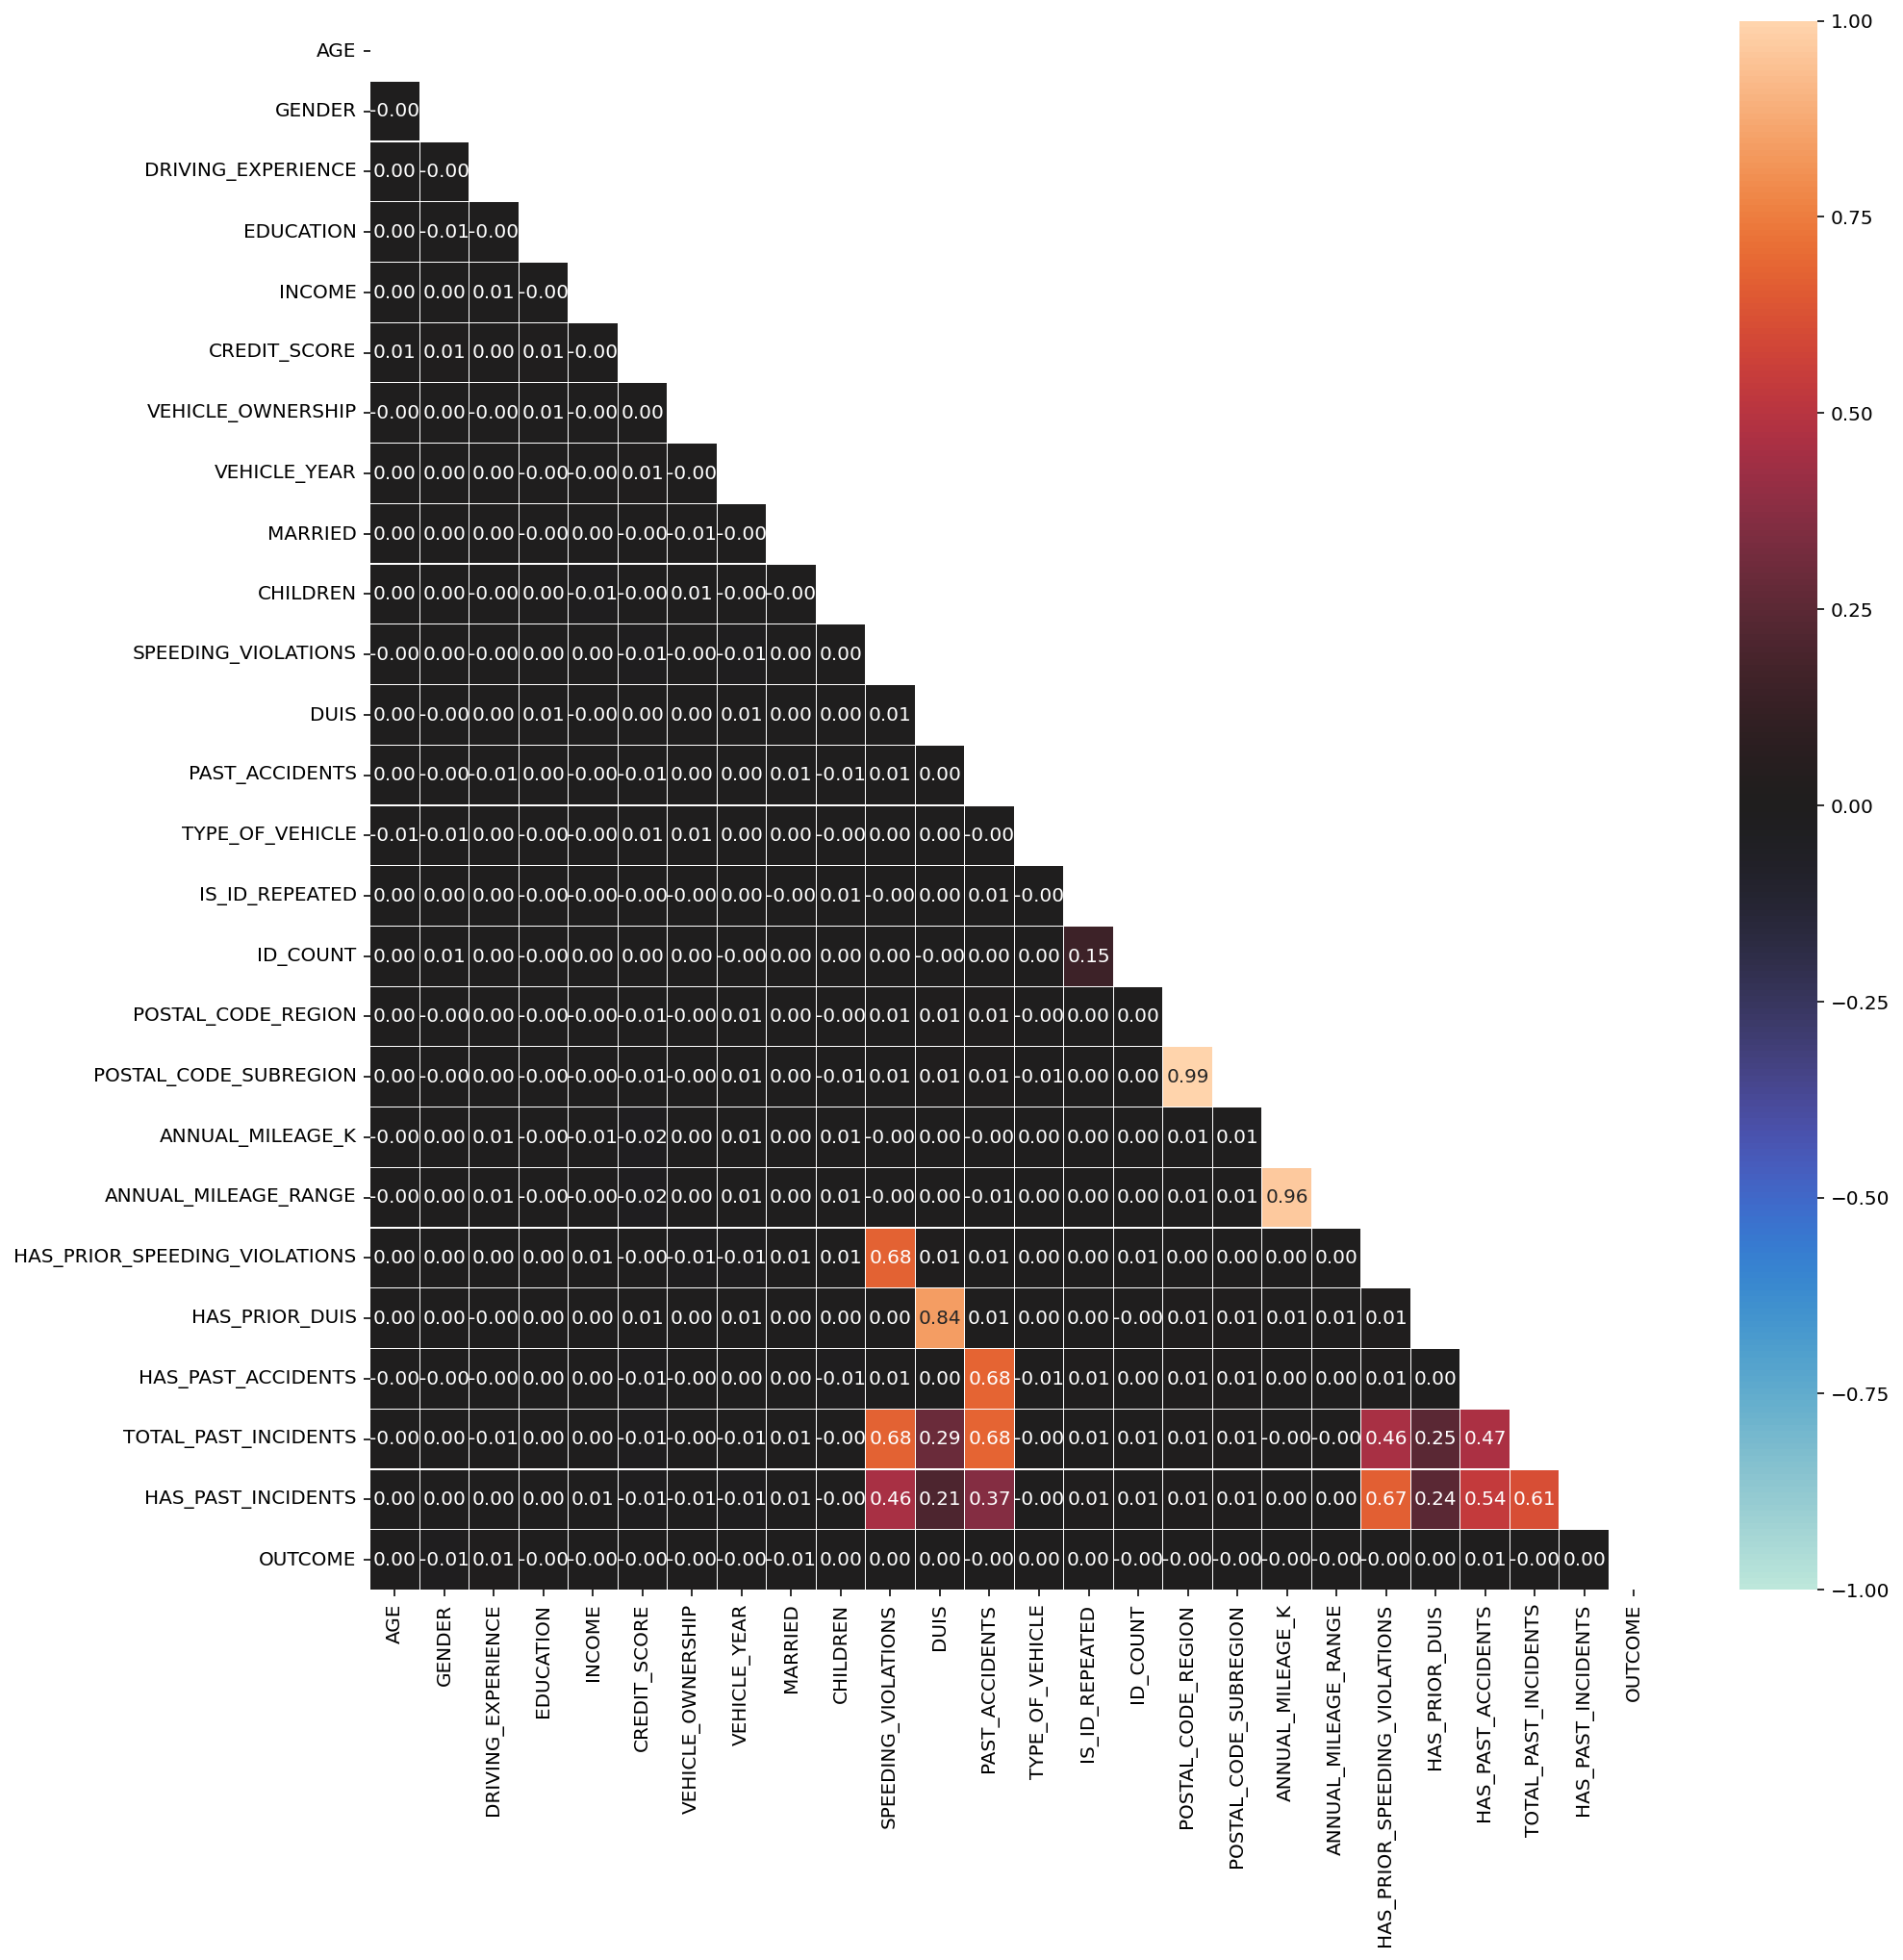

In [128]:
plot_corr_matrix(corr_df)

Apart from the derived features, there is no correlation between features.  
The target variable also has no correlation with any feature, whether original or derived.

### ANOVA F-test

In [129]:
anova_test = f_classif(train[num_features], train[TARGET])

pd.DataFrame(
    data={
        'f-statistic': anova_test[0], 
        'p-value': anova_test[1],
        'accepted?': anova_test[1] < 0.05
    },
    index=num_features
)

,f-statistic,p-value,accepted?
ID_COUNT,0.0140,0.9058,False
CREDIT_SCORE,0.9884,0.3201,False
ANNUAL_MILEAGE_K,0.1280,0.7205,False
DUIS,0.0153,0.9014,False
SPEEDING_VIOLATIONS,0.0024,0.9610,False
PAST_ACCIDENTS,0.5763,0.4477,False
TOTAL_PAST_INCIDENTS,0.2002,0.6546,False


### Chi-squared test of independence

In [130]:
chi2_test = chi2(train[cat_features], train[TARGET])

pd.DataFrame(
    data={
        'f-statistic': chi2_test[0], 
        'p-value': chi2_test[1],
        'accepted?': chi2_test[1] < 0.05
    },
    index=cat_features
)

,f-statistic,p-value,accepted?
AGE,0.4221,0.5159,False
GENDER,5.4259,0.0198,True
DRIVING_EXPERIENCE,7.9399,0.0048,True
EDUCATION,0.5437,0.4609,False
INCOME,0.0065,0.9360,False
VEHICLE_OWNERSHIP,0.1716,0.6787,False
VEHICLE_YEAR,0.0422,0.8372,False
MARRIED,1.5865,0.2078,False
CHILDREN,0.1761,0.6747,False
TYPE_OF_VEHICLE,0.6814,0.4091,False


### Mutual Information score

In [131]:
mi_scores = mutual_info_classif(train[features], train[TARGET], random_state=SEED)

pd.DataFrame(
    data={'mi_score': mi_scores}, 
    index=features
).T

,AGE,GENDER,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,TYPE_OF_VEHICLE,IS_ID_REPEATED,ID_COUNT,POSTAL_CODE_REGION,POSTAL_CODE_SUBREGION,ANNUAL_MILEAGE_K,ANNUAL_MILEAGE_RANGE,HAS_PRIOR_SPEEDING_VIOLATIONS,HAS_PRIOR_DUIS,HAS_PAST_ACCIDENTS,TOTAL_PAST_INCIDENTS,HAS_PAST_INCIDENTS
mi_score,0.0009,0.0054,0.0061,0.0021,0.0054,0.0,0.0088,0.004,0.0042,0.0032,0.0002,0.0006,0.0018,0.0055,0.0011,0.0092,0.006,0.0036,0.0,0.0046,0.0,0.0,0.0,0.0,0.0014


### Feature sets

In [132]:
#based on F-test and Chi2-test
reduced_features = ['GENDER', 'DRIVING_EXPERIENCE', 'POSTAL_CODE_SUBREGION']

#based on mutual information score
mi_features = ['ID_COUNT', 'AGE', 'GENDER', 'DRIVING_EXPERIENCE', 'EDUCATION', 
               'INCOME', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN', 
               'TYPE_OF_VEHICLE', 'POSTAL_CODE_REGION', 'POSTAL_CODE_SUBREGION',
               'ANNUAL_MILEAGE_RANGE']

# Baseline

In [133]:
X, y = train[features], train[TARGET]
X_test = test[features]

### RandomForest

In [136]:
%%time
scores = []
test_preds_rf = {}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    X_train, y_train = X.loc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.loc[val_idx], y.iloc[val_idx]

    model = RandomForestClassifier(
        n_estimators=500, 
        criterion='entropy', 
        max_depth=7,
        # class_weight='balanced',
        n_jobs=-1, 
        random_state=SEED
    )

    model.fit(X_train, y_train)
    val_probs = model.predict_proba(X_val)[:, 1]
    test_preds_rf[f'fold{fold}'] = model.predict_proba(X_test)[:, 1]

    score = log_loss(y_val, val_probs)
    scores.append(score)
    print(f'Fold #{fold}: Logloss = {score:.5f}')
    _ = gc.collect()

print(f'\nAvg Logloss = {np.mean(scores):.5f} +/- {np.std(scores):.5f}\n')

test_preds_rf = pd.DataFrame.from_dict(test_preds_rf)
test_preds_rf['mean'] = test_preds_rf.mean(axis=1)

Fold #0: Logloss = 0.68128
Fold #1: Logloss = 0.68102
Fold #2: Logloss = 0.68109
Fold #3: Logloss = 0.68107
Fold #4: Logloss = 0.68100

Avg Logloss = 0.68109 +/- 0.00010

CPU times: user 3min 9s, sys: 1.8 s, total: 3min 10s
Wall time: 1min 50s


### LogisticRegression

In [137]:
%%time
scores = []
test_preds_lr = {}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    X_train, y_train = X.loc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.loc[val_idx], y.iloc[val_idx]

    model = LogisticRegression(
        C=10,
        max_iter=5000, 
        # class_weight='balanced',
        n_jobs=-1,
        random_state=SEED
    )

    model.fit(X_train, y_train)
    val_probs = model.predict_proba(X_val)[:, 1]
    test_preds_lr[f'fold{fold}'] = model.predict_proba(X_test)[:, 1]

    score = log_loss(y_val, val_probs)
    scores.append(score)
    print(f'Fold #{fold}: Logloss = {score:.5f}')
    _ = gc.collect()

print(f'\nAvg Logloss = {np.mean(scores):.5f} +/- {np.std(scores):.5f}\n')

test_preds_lr = pd.DataFrame.from_dict(test_preds_lr)
test_preds_lr['mean'] = test_preds_lr.mean(axis=1)

Fold #0: Logloss = 0.68143
Fold #1: Logloss = 0.68093
Fold #2: Logloss = 0.68109
Fold #3: Logloss = 0.68100
Fold #4: Logloss = 0.68116

Avg Logloss = 0.68112 +/- 0.00017

CPU times: user 775 ms, sys: 543 ms, total: 1.32 s
Wall time: 15.2 s


# Submission files

In [138]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [139]:
NOTEBOOK = '00'
SUBMISSION_PATH = f'/content/drive/MyDrive/data_science_competitions/machinehack/analytics_olympiad22/submissions/nb_{NOTEBOOK}'
if not os.path.isdir(SUBMISSION_PATH):
    os.makedirs(SUBMISSION_PATH)

In [140]:
def create_submission_files(test_preds, model_name):
    for col in test_preds.columns:
        sub = sample_sub.copy()
        sub['OUTCOME'] = test_preds[col]
        sub.to_csv(f'{SUBMISSION_PATH}/{model_name}_{col}.csv', index=False)

In [141]:
create_submission_files(test_preds_rf, 'rf')

In [142]:
create_submission_files(test_preds_lr, 'lr')

**All zeros**

In [143]:
sub = sample_sub.copy()
sub['OUTCOME'] = 0
sub.to_csv(f'{SUBMISSION_PATH}/all_zeros.csv', index=False)

**All ones**

In [144]:
sub = sample_sub.copy()
sub['OUTCOME'] = 1
sub.to_csv(f'{SUBMISSION_PATH}/all_ones.csv', index=False)

**Randomized replacement with inverse probabilites**

In [145]:
sub = sample_sub.copy()
sub['OUTCOME'] = 0.42

indices_to_replace = sub['OUTCOME'].sample(frac=0.42, random_state=SEED).index
sub.loc[indices_to_replace, 'OUTCOME'] = 0.58

sub.to_csv(f'{SUBMISSION_PATH}/random_replacement.csv', index=False)